## Targeted Classifier Experiment


In [2]:
%load_ext autoreload
%autoreload 2

import sklearn
import json


with open("../../data/dataset.json") as f:
    data = json.load(f)


## Exploratorio

In [3]:
def is_mixed(instance):
    return len(set(instance["labels"].values())) >= 2

len([x for x in data if is_mixed(x)]), len(data)

(160, 1930)

In [4]:
[x for x in data if is_mixed(x)]

[{'titulo': 'Entre el milagro de Macri y la grieta del peronismo',
  'id': 39,
  'labels': {'Macri': 'POS', 'peronismo': 'NEG'}},
 {'titulo': 'Tras plantar a Macri, Acevedo recibe a Alberto Fernández en la UIA',
  'id': 951,
  'labels': {'Macri': 'NEG', 'Alberto Fernández': 'POS'}},
 {'titulo': 'Alberto Fernández rechazó las promesas de Macri: “Lo único que hizo fue sumergir en la pobreza a 5 millones de argentinos”',
  'id': 1265,
  'labels': {'Macri': 'NEG', 'Alberto Fernández': 'POS'}},
 {'titulo': 'Miguel Ángel Pichetto en el acto a favor de Macri: “Si gana Fernández gana Cristina, y va a gobernar ella”',
  'id': 1282,
  'labels': {'Miguel Ángel Pichetto': 'POS',
   'Macri': 'POS',
   'Fernández': 'NEG',
   'Cristina': 'NEG'}},
 {'titulo': 'Roberto Lavagna criticó el discurso de Mauricio Macri: “No es cierto, hoy no estamos mejor para empezar a crecer”',
  'id': 1286,
  'labels': {'Roberto Lavagna': 'POS', 'Mauricio Macri': 'NEG'}},
 {'titulo': 'La sugerencia de Cristina Kirchner a

In [5]:

len([x for x in data if len(x["labels"]) > 1]), len(data)

(396, 1930)

In [6]:
import pandas as pd

label2id = {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
}

id2label = {v:k for k, v in label2id.items()}

def build_auxiliary_sentence(target):
    return f"¿Qué pensás de {target}?"

def build_df(data):
    return pd.DataFrame([{
        "id": x["id"],
        "sentence": x["titulo"],
        "target": target,
        "auxiliary_sentence": build_auxiliary_sentence(target),
        "label": label2id[label],
    } for x in data for (target, label) in x["labels"].items()])

Bien, está dentro de todo equilibrado

## Train test split

Lo hago sobre el dataset. No sería mejor hacerlo por oraciones?

In [7]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, random_state=2021, stratify=[len(x["labels"]) for x in data])

train_data, dev_data = train_test_split(train_data, random_state=2021, stratify=[len(x["labels"]) for x in train_data])

len(train_data), len(dev_data), len(test_data)

(1085, 362, 483)

## Armar dataset

In [8]:
from datasets import Dataset, Value, ClassLabel, Features

train_df = build_df(train_data)
dev_df = build_df(dev_data)
test_df = build_df(test_data)

features = Features({
    'sentence': Value('string'),
    'auxiliary_sentence': Value('string'),
    'label': ClassLabel(num_classes=3, names=["neg", "neu", "pos"])
})

columns = ["sentence", "auxiliary_sentence", "label"]

train_dataset = Dataset.from_pandas(train_df[columns], features=features)
dev_dataset = Dataset.from_pandas(dev_df[columns], features=features)
test_dataset = Dataset.from_pandas(test_df[columns], features=features)

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = 'dccuchile/bert-base-spanish-wwm-uncased'

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, return_dict=True, num_labels=len(id2label)
)

model.config.id2label = id2label
model.config.label2id = label2id

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.model_max_length = 128


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [10]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

In [11]:
def tokenize(batch):
    return tokenizer(batch['sentence'], batch['auxiliary_sentence'], padding='max_length', truncation=True)

batch_size = 16
eval_batch_size = 8

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=batch_size)
dev_dataset = dev_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)

(array([ 20., 124., 218., 392., 257., 192.,  98.,  23.,   7.,   5.]),
 array([16. , 19.6, 23.2, 26.8, 30.4, 34. , 37.6, 41.2, 44.8, 48.4, 52. ]),
 <BarContainer object of 10 artists>)

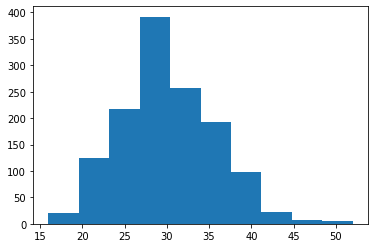

In [12]:
import matplotlib.pyplot as plt

lens = [sum(x["attention_mask"]) for x in train_dataset]


plt.hist(lens)

In [13]:
train_dataset[0].keys()

dict_keys(['attention_mask', 'auxiliary_sentence', 'input_ids', 'label', 'sentence', 'token_type_ids'])

In [14]:

def format_dataset(dataset):
    dataset = dataset.map(lambda x: {"labels": x["label"]})
    columns = ['input_ids', 'attention_mask', 'labels']
    if 'token_type_ids' in dataset.features:
        columns.append('token_type_ids')
    dataset.set_format(type='torch', columns=columns)
    return dataset

train_dataset = format_dataset(train_dataset)
dev_dataset = format_dataset(dev_dataset)
test_dataset = format_dataset(test_dataset)


In [15]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred, id2label):
    """
    Compute metrics for Trainer
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    ret = {}

    f1s = []
    precs = []
    recalls = []

    for i, cat in id2label.items():
        cat_labels, cat_preds = labels == i, preds == i
        precision, recall, f1, _ = precision_recall_fscore_support(
            cat_labels, cat_preds, average='binary', zero_division=0,
        )

        f1s.append(f1)
        precs.append(precision)
        recalls.append(recall)

        ret[cat.lower()+"_f1"] = f1
        ret[cat.lower()+"_precision"] = precision
        ret[cat.lower()+"_recall"] = recall

    _, _, micro_f1, _ = precision_recall_fscore_support(
        labels, preds, average="micro"
    )
    ret["micro_f1"] = micro_f1
    ret["macro_f1"] = torch.Tensor(f1s).mean()
    ret["macro_precision"] = torch.Tensor(precs).mean()
    ret["macro_recall"] = torch.Tensor(recalls).mean()

    ret["acc"] = accuracy_score(labels, preds)

    return ret

epochs = 10
warmup_proportion = 0.10
total_steps = (epochs * len(train_dataset)) // batch_size
warmup_steps = int(warmup_proportion * total_steps)

training_args = TrainingArguments(
    output_dir='./results/',
    num_train_epochs=epochs,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    warmup_steps=warmup_steps,
    evaluation_strategy="epoch",
    do_eval=False,
    weight_decay=0.01,
    logging_dir='./logs',
    #load_best_model_at_end=True,
    #metric_for_best_model="macro_f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=lambda x: compute_metrics(x, id2label=id2label),
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Neg F1,Neg Precision,Neg Recall,Neu F1,Neu Precision,Neu Recall,Pos F1,Pos Precision,Pos Recall,Micro F1,Macro F1,Macro Precision,Macro Recall,Acc,Runtime,Samples Per Second
1,No log,0.957190,0.472868,0.451852,0.495935,0.419048,0.628571,0.314286,0.630332,0.554167,0.730769,0.534831,0.507416,0.544863,0.513663,0.534831,4.263300,104.380000
2,No log,0.848528,0.624390,0.780488,0.520325,0.600707,0.594406,0.607143,0.716418,0.654545,0.791209,0.658427,0.647172,0.676480,0.639559,0.658427,4.108200,108.319000
3,No log,0.913707,0.589641,0.578125,0.601626,0.547619,0.616071,0.492857,0.713178,0.673171,0.758242,0.631461,0.616813,0.622456,0.617575,0.631461,4.365400,101.937000
4,No log,1.143272,0.642857,0.573248,0.731707,0.558824,0.575758,0.542857,0.698225,0.756410,0.648352,0.638202,0.633302,0.635139,0.640972,0.638202,4.175700,106.568000
5,No log,1.281066,0.666667,0.675000,0.658537,0.651466,0.598802,0.714286,0.741176,0.797468,0.692308,0.689888,0.686436,0.690424,0.688377,0.689888,2.838100,156.795000
6,0.465300,1.600379,0.649057,0.605634,0.699187,0.597786,0.618321,0.578571,0.751412,0.773256,0.730769,0.674157,0.666085,0.665737,0.669509,0.674157,4.355400,102.173000
7,0.465300,1.872544,0.593607,0.677083,0.528455,0.570312,0.629310,0.521429,0.708434,0.630901,0.807692,0.640449,0.624118,0.645765,0.619192,0.640449,4.086200,108.903000
8,0.465300,1.906457,0.602740,0.687500,0.536585,0.627986,0.601307,0.657143,0.703704,0.678571,0.730769,0.653933,0.644810,0.655793,0.641499,0.653933,3.872100,114.925000
9,0.465300,1.895775,0.621849,0.643478,0.601626,0.572549,0.634783,0.521429,0.725441,0.669767,0.791209,0.653933,0.639946,0.649343,0.638088,0.653933,2.143900,207.569000
10,0.465300,1.887646,0.618026,0.654545,0.585366,0.583026,0.603053,0.564286,0.709845,0.671569,0.752747,0.647191,0.636965,0.643056,0.634133,0.647191,2.261000,196.813000


TrainOutput(global_step=840, training_loss=0.28821763197580974, metrics={'train_runtime': 380.1869, 'train_samples_per_second': 2.209, 'total_flos': 1127146428149760.0, 'epoch': 10.0, 'init_mem_cpu_alloc_delta': 54307, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18258, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 489406, 'train_mem_gpu_alloc_delta': 1342120448, 'train_mem_cpu_peaked_delta': 96058022, 'train_mem_gpu_peaked_delta': 1790075904})

In [17]:
trainer.evaluate(dev_dataset)

{'eval_loss': 1.8876456022262573,
 'eval_neg_f1': 0.6180257510729614,
 'eval_neg_precision': 0.6545454545454545,
 'eval_neg_recall': 0.5853658536585366,
 'eval_neu_f1': 0.5830258302583026,
 'eval_neu_precision': 0.6030534351145038,
 'eval_neu_recall': 0.5642857142857143,
 'eval_pos_f1': 0.7098445595854923,
 'eval_pos_precision': 0.6715686274509803,
 'eval_pos_recall': 0.7527472527472527,
 'eval_micro_f1': 0.647191011235955,
 'eval_macro_f1': 0.6369653940200806,
 'eval_macro_precision': 0.6430558562278748,
 'eval_macro_recall': 0.6341329216957092,
 'eval_acc': 0.647191011235955,
 'eval_runtime': 2.2419,
 'eval_samples_per_second': 198.488,
 'epoch': 10.0,
 'eval_mem_cpu_alloc_delta': 63652,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 129050,
 'eval_mem_gpu_peaked_delta': 35431936}

In [18]:
model = trainer.model

In [55]:
from torch.nn import functional as F
def predict(sentence, target):
    """
    Return most likely class for the sentence
    """
    idx = torch.LongTensor(tokenizer.encode(sentence, build_auxiliary_sentence(target))).view(1, -1).to(device)
    output = model(idx)
    probs = F.softmax(output.logits, dim=1).view(-1)
    probas = {id2label[i]:probs[i].item() for i in id2label}

    return probas



In [56]:
sentence = "Gran 2020 para Messi, pero bastante malo para Cristiano Ronaldo"

targets = ["Messi", "Cristiano Ronaldo"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Messi
{'NEG': 0.9976414442062378, 'NEU': 0.0007326872437261045, 'POS': 0.0016259176190942526}
Cristiano Ronaldo
{'NEG': 0.9979167580604553, 'NEU': 0.0008845353149808943, 'POS': 0.0011986682657152414}


In [57]:
sentence = "Alberto Fernández: \"El gobierno de Macri fue un desastre\""

targets = ["Alberto Fernández", "Macri"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Alberto Fernández
{'NEG': 0.2877868115901947, 'NEU': 0.006987974978983402, 'POS': 0.7052252888679504}
Macri
{'NEG': 0.9987339377403259, 'NEU': 0.00025105723761953413, 'POS': 0.0010149517329409719}


In [58]:
sentence = "Alberto Fernández: \"El gobierno de Xi Jin Ping fue un desastre\""

targets = ["Alberto Fernández", "Xi Jin Ping"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Alberto Fernández
{'NEG': 0.961915135383606, 'NEU': 0.0007963121752254665, 'POS': 0.03728855401277542}
Xi Jin Ping
{'NEG': 0.9982432126998901, 'NEU': 0.00028047195519320667, 'POS': 0.0014762660721316934}


In [59]:
sentence = "Romina Del Plá denunció el ajuste de Alberto Fernández"

targets = ["Romina del Plá", "Alberto Fernández"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Romina del Plá
{'NEG': 0.0002518059918656945, 'NEU': 0.9815942049026489, 'POS': 0.018154017627239227}
Alberto Fernández
{'NEG': 0.00020101014524698257, 'NEU': 0.9985156655311584, 'POS': 0.001283268560655415}


In [60]:
sentence = "El Gobierno mejora la compra de vacunas"

targets = ["Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.2081679105758667, 'NEU': 0.7289620637893677, 'POS': 0.06287003308534622}


In [61]:
sentence = "Cristina Kirchner acusa al Gobierno de corrupción en la compra de vacunas"

targets = ["Gobierno", "Cristina Kirchner"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.9988759160041809, 'NEU': 0.0005053963977843523, 'POS': 0.0006187394610606134}
Cristina Kirchner
{'NEG': 0.0017923321574926376, 'NEU': 0.014108126983046532, 'POS': 0.9840995073318481}


In [62]:
sentence = "El duro comunicado de las empresas estadounidenses contra el Gobierno"

targets = ["Gobierno", "empresas estadounidenses"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.9987296462059021, 'NEU': 0.00045331663568504155, 'POS': 0.0008169397478923202}
empresas estadounidenses
{'NEG': 0.9970159530639648, 'NEU': 0.0008322632638737559, 'POS': 0.002151880878955126}


In [63]:
sentence = "Ultiman negociaciones para cerrar acuerdo en la Ciudad entre Vidal y Bullrich"

targets = ["Vidal", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Vidal
{'NEG': 0.0003200665523763746, 'NEU': 0.9993281364440918, 'POS': 0.0003518470039125532}
Bullrich
{'NEG': 0.0003305832215119153, 'NEU': 0.9993003606796265, 'POS': 0.0003690874145831913}


In [64]:
sentence = "\"Este Gobierno ha sido una lacra corrupta inmunda\" declaró Patricia Bullrich"

targets = ["Gobierno", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.9983116388320923, 'NEU': 0.0002303018991369754, 'POS': 0.0014580382267013192}
Bullrich
{'NEG': 0.004306693095713854, 'NEU': 0.9869821667671204, 'POS': 0.008711190894246101}


Si lo ponemos adelante, sin embargo...

In [65]:
sentence = "Patricia Bullrich: \"Este Gobierno ha sido una lacra corrupta inmunda\""

targets = ["Gobierno", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.9979864358901978, 'NEU': 0.0002553400699980557, 'POS': 0.0017583029111847281}
Bullrich
{'NEG': 0.987626850605011, 'NEU': 0.0003981756744906306, 'POS': 0.011975035071372986}


In [66]:
sentence = "Keiko: 'Pedro Castillo es un pésimo dirigente, pero por suerte este Gobierno es lo mejor que le ha pasado a Perú'"

targets = ["Keiko", "Pedro Castillo", "Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Keiko
{'NEG': 0.000635691627394408, 'NEU': 0.985283613204956, 'POS': 0.01408066414296627}
Pedro Castillo
{'NEG': 0.0005387677811086178, 'NEU': 0.003077590139582753, 'POS': 0.9963836669921875}
Gobierno
{'NEG': 0.9742252230644226, 'NEU': 0.0023524558637291193, 'POS': 0.02342231199145317}


In [67]:
[x for x in test_data if is_mixed(x) and "\"" not in x["titulo"]]

[{'titulo': 'Para Miguel Pichetto, el ganador del debate fue Mauricio Macri: “Alberto Fernández fue muy agresivo y arrogante”',
  'id': 13817,
  'labels': {'Miguel Pichetto': 'POS',
   'Mauricio Macri': 'POS',
   'Alberto Fernández': 'NEG'}},
 {'titulo': 'Alberto Fernández cruzó a Mauricio Macri por la referencia a San Martín: “Usted solo supo entregar el país al FMI, nada heroico hizo”',
  'id': 7427,
  'labels': {'Mauricio Macri': 'NEG', 'Alberto Fernández': 'POS'}},
 {'titulo': 'En un debate con pocas propuestas, Mauricio Macri defendió su gestión y Alberto Fernández jugó a atacarlo',
  'id': 13801,
  'labels': {'Mauricio Macri': 'POS', 'Alberto Fernández': 'NEG'}},
 {'titulo': 'Alberto Fernández pidió al Gobierno “que haga menos daño” rumbo a diciembre',
  'id': 7429,
  'labels': {'Gobierno': 'NEG', 'Alberto Fernández': 'POS'}},
 {'titulo': 'Lavagna busca quebrar la polarización con críticas a Macri y Alberto Fernández',
  'id': 9348,
  'labels': {'Lavagna': 'POS', 'Macri': 'NEG', 

In [69]:
for instance in [x for x in test_data if is_mixed(x)]:
    print("="*80)
    print(instance["labels"])
    sentence = instance["titulo"]
    print(sentence)

    targets = instance["labels"].keys()

    for target in targets:
        print(target)
        print(predict(sentence, target))

{'Mauricio Macri': 'NEG', 'Alberto Fernández': 'POS'}
Alberto Fernández cruzó a Mauricio Macri por la mención a San Martín: "Nada heroico hizo usted"
Mauricio Macri
{'NEG': 0.019803356379270554, 'NEU': 0.979007363319397, 'POS': 0.0011892936890944839}
Alberto Fernández
{'NEG': 0.000800758192781359, 'NEU': 0.9301235675811768, 'POS': 0.06907561421394348}
{'Mauricio Macri': 'NEU', 'Alberto Fernández': 'POS'}
Alberto Fernández le pidió a Mauricio Macri que "no libere el dólar" si pierde las elecciones
Mauricio Macri
{'NEG': 0.9549865126609802, 'NEU': 0.04313255101442337, 'POS': 0.001880901399999857}
Alberto Fernández
{'NEG': 0.01457690354436636, 'NEU': 0.48622241616249084, 'POS': 0.4992006719112396}
{'Miguel Pichetto': 'POS', 'Mauricio Macri': 'POS', 'Alberto Fernández': 'NEG'}
Para Miguel Pichetto, el ganador del debate fue Mauricio Macri: “Alberto Fernández fue muy agresivo y arrogante”
Miguel Pichetto
{'NEG': 0.1931944340467453, 'NEU': 0.0021232543513178825, 'POS': 0.8046823143959045}
Ma